In [1]:
%cd "/content/drive/MyDrive/projects/violence"


/content/drive/MyDrive/projects/violence


In [2]:
import numpy as np
from glob import glob
import os
from torchvision import datasets


from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True



batch_size = 10
num_workers = 0

data_dir = 'dataset'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'val/')

In [3]:
standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'val': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     standard_normalization])}

In [4]:
train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['val'])

In [5]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)

In [6]:
loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader}

In [7]:
torch.cuda.is_available()

True

In [8]:
loaders_transfer = loaders_scratch.copy()


use_cuda = torch.cuda.is_available()

In [10]:
import torch.nn as nn
import torchvision.models as models

## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.fc = nn.Linear(2048, 2, bias=True)


fc_parameters = model_transfer.fc.parameters()


for param in fc_parameters:
    param.requires_grad = True


if use_cuda:
    model_transfer = model_transfer.cuda()


import pickle
pickle.dump(model_transfer,open("resnetmain.pkl","wb"))

In [11]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

In [12]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            state = {'epoch': epoch + 1, 'state_dict': model.state_dict(), 

                     'optimizer': optimizer.state_dict(), 'loss': loss, }
            torch.save(state, save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [13]:
train(50, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'main_model.pt')

Epoch 1, Batch 1 loss: 0.817353


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: 1 	Training Loss: 0.678311 	Validation Loss: 0.604211
Validation loss decreased (inf --> 0.604211).  Saving model ...
Epoch 2, Batch 1 loss: 0.608315
Epoch: 2 	Training Loss: 0.614031 	Validation Loss: 0.545913
Validation loss decreased (0.604211 --> 0.545913).  Saving model ...
Epoch 3, Batch 1 loss: 0.566526
Epoch: 3 	Training Loss: 0.570078 	Validation Loss: 0.489787
Validation loss decreased (0.545913 --> 0.489787).  Saving model ...
Epoch 4, Batch 1 loss: 0.485546
Epoch: 4 	Training Loss: 0.543217 	Validation Loss: 0.468349
Validation loss decreased (0.489787 --> 0.468349).  Saving model ...
Epoch 5, Batch 1 loss: 0.498120
Epoch: 5 	Training Loss: 0.543946 	Validation Loss: 0.439542
Validation loss decreased (0.468349 --> 0.439542).  Saving model ...
Epoch 6, Batch 1 loss: 0.454246
Epoch: 6 	Training Loss: 0.511613 	Validation Loss: 0.432152
Validation loss decreased (0.439542 --> 0.432152).  Saving model ...
Epoch 7, Batch 1 loss: 0.639192
Epoch: 7 	Training Loss: 0.495009

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
import pickle
model = pickle.load(open("resnetmain.pkl","rb"))

In [15]:
import torch
checkpoint = torch.load("main_model.pt")

In [16]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [17]:
class_names = loaders_transfer['train'].dataset.classes
print(class_names)

['safe', 'unsafe']


In [18]:
from PIL import Image
import torchvision.transforms as transforms

def load_input_image(img_path):    
    image = Image.open(img_path).convert('RGB')
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [19]:
def predict_image(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

In [20]:
import matplotlib.pyplot as plt                        
%matplotlib inline  

def run_app(img_path):
    
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    
    prediction = predict_image(model, class_names, img_path)
        
    return prediction

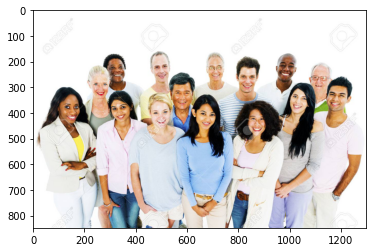

'safe'

In [21]:
run_app("/content/drive/MyDrive/projects/violence/dataset/train/safe/49152357-group-of-casual-people-social-gathering-concept.jpg")

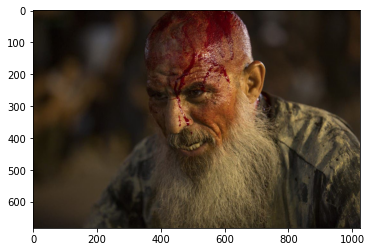

'unsafe'

In [22]:
run_app("/content/drive/MyDrive/projects/violence/dataset/train/unsafe/000_1K49DO.jpg")